In [9]:
import h5py

with h5py.File("/media/hdd1/neo/TCGA-LUSC_ResNet/TCGA-6A-AB49-01Z-00-DX1.FDF2EED7-57A3-4019-A382-21DED11780F6-patch_features.h5", "r") as f:
    print(list(f.keys())) 
    print(f["features"].shape)
    print(f["coords"].shape)
    print(f["patch_grid_idx"][6])

['coords', 'features', 'patch_grid_idx']
(14695, 1024)
(14695, 2)
619


In [32]:
from pathlib import Path
import pandas as pd
import h5py
from tqdm import tqdm
import torch 

# --- base output path ---
data_dir = Path("/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc")
pq_dir = data_dir / "parquet"
pq_dir.mkdir(parents=True, exist_ok=True)

tiles_parquet = pq_dir / "tiles.parquet"
features_parquet = pq_dir / "features.parquet"
labels_parquet = pq_dir / "slide_labels.parquet"
labels_parquet.parent.mkdir(parents=True, exist_ok=True)

# --- dataset definitions ---
datasets = {
    "lusc": {
        "wsi_dir": Path("/media/ssd1/TCGA_WSI/TCGA-LUSC"),
        "tile_dir": Path("/media/ssd1/TCGA_WSI_Patches/TCGA-LUSC"),
        "info_dir": Path("/media/ssd1/TCGA_WSI_PG/TCGA_LUSC"),
        "feature_dir": Path("/media/ssd1/TCGA_WSI_PF/TCGA_LUSC/resnet_cycle_0"),
    },
    "luad": {
        "wsi_dir": Path("/media/ssd1/TCGA_WSI/TCGA-LUAD"),
        "tile_dir": Path("/media/ssd1/TCGA_WSI_Patches/TCGA-LUAD"),
        "info_dir": Path("/media/ssd1/TCGA_WSI_PG/TCGA_LUAD"),
        "feature_dir": Path("/media/ssd1/TCGA_WSI_PF/TCGA_LUAD/resnet_cycle_0"),
    },
}

tile_records = []
feature_records = []
label_records = []

for label, cfg in datasets.items():
    wsi_dir = cfg["wsi_dir"]
    tile_dir = cfg["tile_dir"]
    info_dir = cfg["info_dir"]
    feature_dir = cfg["feature_dir"]

    svs_paths = sorted(wsi_dir.glob("*.svs"))
    
    for svs_path in tqdm(svs_paths, desc=f"Processing {label.upper()}"):
        slide_id = svs_path.stem
        patch_csv = info_dir / slide_id / "patch_metadata.csv"
        if not patch_csv.exists():
            print(f"⚠️ Missing patch_metadata.csv for {slide_id}")
            continue

        patch_info = pd.read_csv(patch_csv)
        # if "include" in patch_info.columns:
        #     patch_info = patch_info[patch_info["include"]].reset_index(drop=True)
        # else:
        #     patch_info = patch_info.reset_index(drop=True)

        # --- tiles ---
        for tile_idx, row in patch_info.iterrows():
            x, y = row["x"], row["y"]
            tile_path = tile_dir / slide_id / f"patch_{tile_idx:06d}.jpg"
            tile_records.append({
                "slide_id": slide_id,
                "patch_grid_idx": row["patch_grid_idx"],
                "x": int(x),
                "y": int(y),
                "patch_uri": str(tile_path),
                "include": row["include"]
            })

        # --- features (one per slide) ---
        feat_path = feature_dir / f"{slide_id}/features.pt"
        if not feat_path.exists():
            print(f"⚠️ Missing feature file for {slide_id}")
            continue

        try:
            feats = torch.load(feat_path)
            n_feats = feats.shape[0] if hasattr(feats, "shape") else len(feats)
        except Exception as e:
            print(f"⚠️ Error reading {feat_path}: {e}")
            continue

        n_patches = len(patch_info)
        if n_feats != n_patches:
            print(f"⚠️ Mismatch for {slide_id}: {n_feats} features vs {n_patches} patches")
            continue

        feature_records.append({
            "slide_id": slide_id,
            "feature_uri": str(feat_path)
        })

        label_records.append({
            "slide_id": slide_id,
            "label": label
        })



# --- write parquet files ---
tiles_df = pd.DataFrame.from_records(tile_records)
tiles_df.to_parquet(tiles_parquet, index=False)
print(f"✅ Saved {len(tiles_df)} rows to {tiles_parquet}")

features_df = pd.DataFrame.from_records(feature_records)
features_df.to_parquet(features_parquet, index=False)
print(f"✅ Saved {len(features_df)} rows to {features_parquet}")

labels_df = pd.DataFrame.from_records(label_records)
labels_df.to_parquet(labels_parquet, index=False)
print(f"✅ Saved {len(labels_df)} rows to {labels_parquet}")


Processing LUAD:   1%|          | 5/541 [00:03<05:22,  1.66it/s]

⚠️ Missing patch_metadata.csv for TCGA-05-4384-01Z-00-DX1.CA68BF29-BBE3-4C8E-B48B-554431A9EE13
⚠️ Missing patch_metadata.csv for TCGA-05-4390-01Z-00-DX1.858E64DF-DD3E-4F43-B7C1-CE35B33F1C90


Processing LUAD:   3%|▎         | 14/541 [00:13<12:16,  1.40s/it]

⚠️ Missing patch_metadata.csv for TCGA-05-4410-01Z-00-DX1.E5B66334-4949-4F45-9200-296B1A2F1AD5


Processing LUAD:   4%|▍         | 21/541 [00:23<13:26,  1.55s/it]

⚠️ Missing patch_metadata.csv for TCGA-05-4425-01Z-00-DX1.82B093EE-49BC-4FD9-91AC-4CC89944309D


Processing LUAD:   5%|▌         | 28/541 [00:31<10:38,  1.24s/it]

⚠️ Missing patch_metadata.csv for TCGA-05-5420-01Z-00-DX1.8C253A99-44FD-48B6-AF31-D808CCB7DB1E
⚠️ Missing patch_metadata.csv for TCGA-05-5423-01Z-00-DX1.CCCF5FDB-ACAD-4D9D-80DF-556F0D6284AF
⚠️ Missing patch_metadata.csv for TCGA-05-5425-01Z-00-DX1.85865B2F-4888-43DD-A501-458BEFCF832B
⚠️ Missing patch_metadata.csv for TCGA-05-5428-01Z-00-DX1.8018AD62-F1CE-4BFF-8EFD-3F2D4513FC11
⚠️ Missing patch_metadata.csv for TCGA-05-5429-01Z-00-DX1.20729065-FADA-4E43-98D7-AFA5FB4A0447
⚠️ Missing patch_metadata.csv for TCGA-05-5715-01Z-00-DX1.D3F0A1FA-2507-45FF-823F-F9981E62BB4C


Processing LUAD: 100%|██████████| 541/541 [17:00<00:00,  1.89s/it]


✅ Saved 33986484 rows to /home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/tiles.parquet
✅ Saved 1043 rows to /home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/features.parquet
✅ Saved 1043 rows to /home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/slide_labels.parquet


In [1]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

# --- paths ---
pq_dir = Path("/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet")
labels_path = pq_dir / "slide_labels.parquet"
splits_path = pq_dir / "split_1_25train.parquet"

# --- load labels ---
labels_df = pd.read_parquet(labels_path)

# --- label distribution ---
print("Label proportions:")
print(labels_df["label"].value_counts(normalize=True))

# --- stratified 70/15/15 split ---
train_df, temp_df = train_test_split(
    labels_df,
    test_size=0.30,
    stratify=labels_df["label"],
    random_state=42,
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42,
)

# --- subsample 25% of training data (stratified) ---
train_sub_df = (
    train_df.groupby("label", group_keys=False)
    .apply(lambda x: x.sample(frac=0.25, random_state=42))
    .reset_index(drop=True)
)

# --- combine with split column ---
train_sub_df = train_sub_df.assign(split="train")
val_df = val_df.assign(split="val")
test_df = test_df.assign(split="test")

splits_df = pd.concat([train_sub_df, val_df, test_df], ignore_index=True)
splits_df.drop(columns=["label"], inplace=True)
splits_df.to_parquet(splits_path, index=False)

print(f"✅ Saved {len(splits_df)} rows to {splits_path}")
print("\nSplit summary:")
print(splits_df["split"].value_counts())

Label proportions:
label
luad    0.509108
lusc    0.490892
Name: proportion, dtype: float64
✅ Saved 496 rows to /home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/split_1_25train.parquet

Split summary:
split
train    183
test     157
val      156
Name: count, dtype: int64


/tmp/ipykernel_1418366/1183010326.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.25, random_state=42))


In [29]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append('..')

from src.data.datasets import SlideDataset

data = SlideDataset(
    split="train",
    labels_parquet="/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/slide_labels.parquet",
    tiles_parquet="/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/tiles.parquet",
    splits_parquet="/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/split_1.parquet",
    features_parquet="/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/features.parquet"
)

sample = data[0]
print("Slide ID:", sample["slide_id"])
print("Label:", sample["label"])
print("Coords shape:", sample["coords"].shape)

view = sample["view"]

# --- fetch image tiles ---
tiles = view.fetch_tiles()  # loads only included tiles (RGB tensors)
print("Tiles tensor:", tiles.shape, tiles.dtype)

# --- fetch features ---
feats = view.fetch_features()
print("Features tensor:", feats.shape, feats.dtype)

# optional: check alignment
assert feats.shape[0] == tiles.shape[0], "Mismatch: features and tiles length differ"
print("✅ Tiles and features aligned.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dog/Documents/van/wsi_samp/notebooks/../src/data/datasets.py:222: UserWarning: No lowres thumbnails found; using first tile as fallback.
  else:


3333
3333
Slide ID: TCGA-05-4244-01Z-00-DX1.d4ff32cd-38cf-40ea-8213-45c2b100ac01
Label: tensor(0)
Coords shape: (3333, 2)
Tiles tensor: torch.Size([3333, 3, 224, 224]) torch.float32
Features tensor: torch.Size([3333, 1024]) torch.float32
✅ Tiles and features aligned.


In [10]:
import pandas as pd 

split = pd.read_parquet( "/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/debug_split.parquet" )
split_sub = split.iloc[0:3]

split_sub.to_parquet( "/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/debug_tiny.parquet", index=False )
split_sub

,slide_id,split
0,TCGA-85-6561-01Z-00-DX1.7bb9f936-00e1-4014-a6a...,test
1,TCGA-78-7153-01Z-00-DX1.5190321a-f1aa-4c6e-b4b...,train
2,TCGA-77-8136-01Z-00-DX1.15cdacc3-ee04-4323-b5e...,val


In [15]:
patches = pd.read_parquet( "/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/tiles.parquet" )

In [37]:
import os 
split = pd.read_parquet( "/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/split_1.parquet" )

patches = pd.read_parquet( "/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/tiles.parquet" )

# subset to your slides of interest
subset = patches[patches["slide_id"].isin(split["slide_id"])].copy()

# derive the directory containing each patch file
subset["patch_dir"] = subset["patch_uri"].apply(os.path.dirname)

# unique directories per slide
slide_dirs = subset.groupby("slide_id")["patch_dir"].first().to_dict()
slide_dirs

KeyboardInterrupt: 

In [19]:
split_sub["slide_id"].values

array(['TCGA-85-6561-01Z-00-DX1.7bb9f936-00e1-4014-a6ae-8dc1c64d7f42',
       'TCGA-78-7153-01Z-00-DX1.5190321a-f1aa-4c6e-b4b9-6767b779682b',
       'TCGA-77-8136-01Z-00-DX1.15cdacc3-ee04-4323-b5e4-4f6d7085bd38'],
      dtype=object)

In [ ]:
import os, lmdb
from tqdm import tqdm

def create_lmdb_for_slide(slide_id, slide_path, out_dir, map_size=1e10):
    os.makedirs(out_dir, exist_ok=True)
    lmdb_path = os.path.join(out_dir, f"{slide_id}.lmdb")
    env = lmdb.open(lmdb_path, map_size=int(map_size))

    patch_files = sorted(os.listdir(slide_path))
    with env.begin(write=True) as txn:
        for fn in tqdm(patch_files, desc=slide_id):
            path = os.path.join(slide_path, fn)
            with open(path, "rb") as f:
                txn.put(fn.encode(), f.read())

    env.close()



patch_dir = '/media/ssd1/TCGA_WSI_Patches/TCGA-LUAD'
out_dir = '/media/ssd1/van/lusc-luad_lmdb/'

for slide_id, slide_dir in slide_dirs.items():
    create_lmdb_for_slide(slide_id, slide_dir, out_dir)

46260 ['patch_000000.jpg', 'patch_000001.jpg', 'patch_000002.jpg', 'patch_000003.jpg', 'patch_000004.jpg']


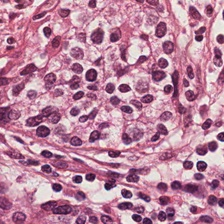

torch.Size([3, 224, 224])


In [15]:
import lmdb, io
from PIL import Image
import torchvision.transforms.functional as TF

env = lmdb.open("/media/ssd1/van/lusc-luad_lmdb/TCGA-77-8136-01Z-00-DX1.15cdacc3-ee04-4323-b5e4-4f6d7085bd38.lmdb", readonly=True, lock=False, readahead=False)

with env.begin(write=False) as txn:
    cursor = txn.cursor()
    keys = [k.decode() for k, _ in cursor]

# keep only image files
img_keys = [k for k in keys if k.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff"))]
print(len(img_keys), img_keys[:5])

# load one
k = img_keys[5000]
with env.begin(write=False) as txn:
    raw = txn.get(k.encode())

img = Image.open(io.BytesIO(raw)).convert("RGB")
display(img)

# to tensor if you want
t = TF.to_tensor(img)
print(t.shape)

In [13]:
split_path = "/home/dog/Documents/van/wsi_samp/data/tcga_luad_lusc/parquet/split_1_25train.parquet"
split = pd.read_parquet(split_path)
split[split["split"].isin(["train", "val"])]

,slide_id,split
0,TCGA-S2-AA1A-01Z-00-DX1.4B5D5FAE-8305-4D2D-B24...,train
1,TCGA-86-7953-01Z-00-DX1.847865ce-df59-4677-bac...,train
2,TCGA-49-4501-01Z-00-DX1.9c4bf212-5e32-449e-871...,train
3,TCGA-55-8090-01Z-00-DX1.83f86d5f-7cb9-443a-a81...,train
4,TCGA-86-6562-01Z-00-DX1.5dea3015-e606-4837-9f9...,train
...,...,...
334,TCGA-39-5037-01Z-00-DX1.02636c3e-c843-4741-8fb...,val
335,TCGA-67-6215-01Z-00-DX1.c014ffaf-6db8-42ef-a50...,val
336,TCGA-86-A4P7-01Z-00-DX1.37026DCF-5A81-4098-B44...,val
337,TCGA-33-4538-01Z-00-DX3.27b62beb-d3c4-493b-866...,val


In [22]:
import pandas as pd

tiles_df    = pd.read_parquet("../data/tcga_luad_lusc/parquet/tiles.parquet")
labels_df   = pd.read_parquet("../data/tcga_luad_lusc/parquet/slide_labels.parquet")
splits_df   = pd.read_parquet("../data/tcga_luad_lusc/parquet/split_1_25train.parquet")
feats_df    = pd.read_parquet("../data/tcga_luad_lusc/parquet/features.parquet")


In [39]:
slide_to_files = (
    tiles_df
    .groupby("slide_id")["patch_uri"]
    .apply(list)
    .to_dict()
)

# Also extract slide_id → list of basenames (keys for LMDB)
slide_to_keys = {
    slide_id: [Path(p).name for p in paths]
    for slide_id, paths in slide_to_files.items()
}

slide_ids = list(slide_to_files.keys())

print("Num slides:", len(slide_ids))
print("Example:", slide_ids[0])
print("Example files:", slide_to_files[slide_ids[0]][:5])
print("Example LMDB keys:", slide_to_keys[slide_ids[0]][:5])


NameError: name 'Path' is not defined